# Fine-tune LayoutLMv3 for token classification on CORD receipts dataset

This notebook shows how to Fine-Tune a LayoutLMv3 model for token classification on the CORD receipt dataset. This notebook can be found at [https://bit.ly/raj_layout](https://bit.ly/raj_layout) and my [github](https://github.com/rajshah4/huggingface-demos/)

This notebook was created by Rajiv Shah. The best set of notebooks for LayoutLM is by Niels at his [Transformer Tutorials](https://github.com/NielsRogge/Transformers-Tutorials).

## Set-up environment

First, we install 🤗 Transformers, as well as 🤗 Datasets and Seqeval (the latter is useful for evaluation metrics such as F1 on sequence labeling tasks).

In [ ]:
!pip install -q datasets seqeval transformers

     |████████████████████████████████| 365 kB 5.2 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 4.7 MB 52.0 MB/s 
     |████████████████████████████████| 120 kB 55.0 MB/s 
     |████████████████████████████████| 212 kB 72.6 MB/s 
     |████████████████████████████████| 115 kB 73.7 MB/s 
     |████████████████████████████████| 127 kB 61.1 MB/s 
     |████████████████████████████████| 6.6 MB 66.9 MB/s 


Let's login to the Hugging Face hub, so we have a place to push our final tuned model.
To create a Hugging Face account if you do not already have one, by visiting https://huggingface.co/ and clicking "Sign Up".  You will then go to your account, look under profile settings, and then select/create an access token with write privileges.  

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Verify you are correctly logged in

In [ ]:
!huggingface-cli whoami

rajistics
orgs:  huggingface,spaces-explorers,demo-org,HF-test-lab,qualitydatalab,FinanceInc,vendorabc


## Load dataset

Next, we load a dataset from the 🤗 [hub](https://huggingface.co/datasets/nielsr/cord-layoutlmv3). This one is the [CORD](https://github.com/clovaai/cord) dataset, a collection of annotated receipts.  

Loading this dataset can take 10 minutes. The generating train split takes a bit.

In [ ]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("nielsr/cord-layoutlmv3")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cord-layoutlmv3 downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___cord-layoutlmv3/cord/1.0.0/581083d58bb5c35fdcfed4f7b36f9a8bf23acfd28e974edc7b8157c972720203. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

As we can see, the dataset consists of 3 splits ("train",  "validation", and "test"), and each example contains a list of words ("words") with corresponding boxes ("bboxes"), and the words are tagged ("ner_tags"). Each example also include the original image ("image"). Check out this [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/CORD/Prepare_CORD_for_LayoutLMv2.ipynb) from Niels for details on how to prepare the CORD dataset. 

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 100
    })
})

Let's check the features. The CORD dataset has a lot!  For a simpler document, check out the FUNSD dataset:

In [ ]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=61, names=['O', 'B-MENU.NM', 'B-MENU.NUM', 'B-MENU.UNITPRICE', 'B-MENU.CNT', 'B-MENU.DISCOUNTPRICE', 'B-MENU.PRICE', 'B-MENU.ITEMSUBTOTAL', 'B-MENU.VATYN', 'B-MENU.ETC', 'B-MENU.SUB_NM', 'B-MENU.SUB_UNITPRICE', 'B-MENU.SUB_CNT', 'B-MENU.SUB_PRICE', 'B-MENU.SUB_ETC', 'B-VOID_MENU.NM', 'B-VOID_MENU.PRICE', 'B-SUB_TOTAL.SUBTOTAL_PRICE', 'B-SUB_TOTAL.DISCOUNT_PRICE', 'B-SUB_TOTAL.SERVICE_PRICE', 'B-SUB_TOTAL.OTHERSVC_PRICE', 'B-SUB_TOTAL.TAX_PRICE', 'B-SUB_TOTAL.ETC', 'B-TOTAL.TOTAL_PRICE', 'B-TOTAL.TOTAL_ETC', 'B-TOTAL.CASHPRICE', 'B-TOTAL.CHANGEPRICE', 'B-TOTAL.CREDITCARDPRICE', 'B-TOTAL.EMONEYPRICE', 'B-TOTAL.MENUTYPE_CNT', 'B-TOTAL.MENUQTY_CNT', 'I-MENU.NM', 'I-MENU.NUM', 'I-MENU.UNITPRICE', 'I-MENU.C

Note that you can directly see the example in a notebook (as the "image" column is of type [Image](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Image)).

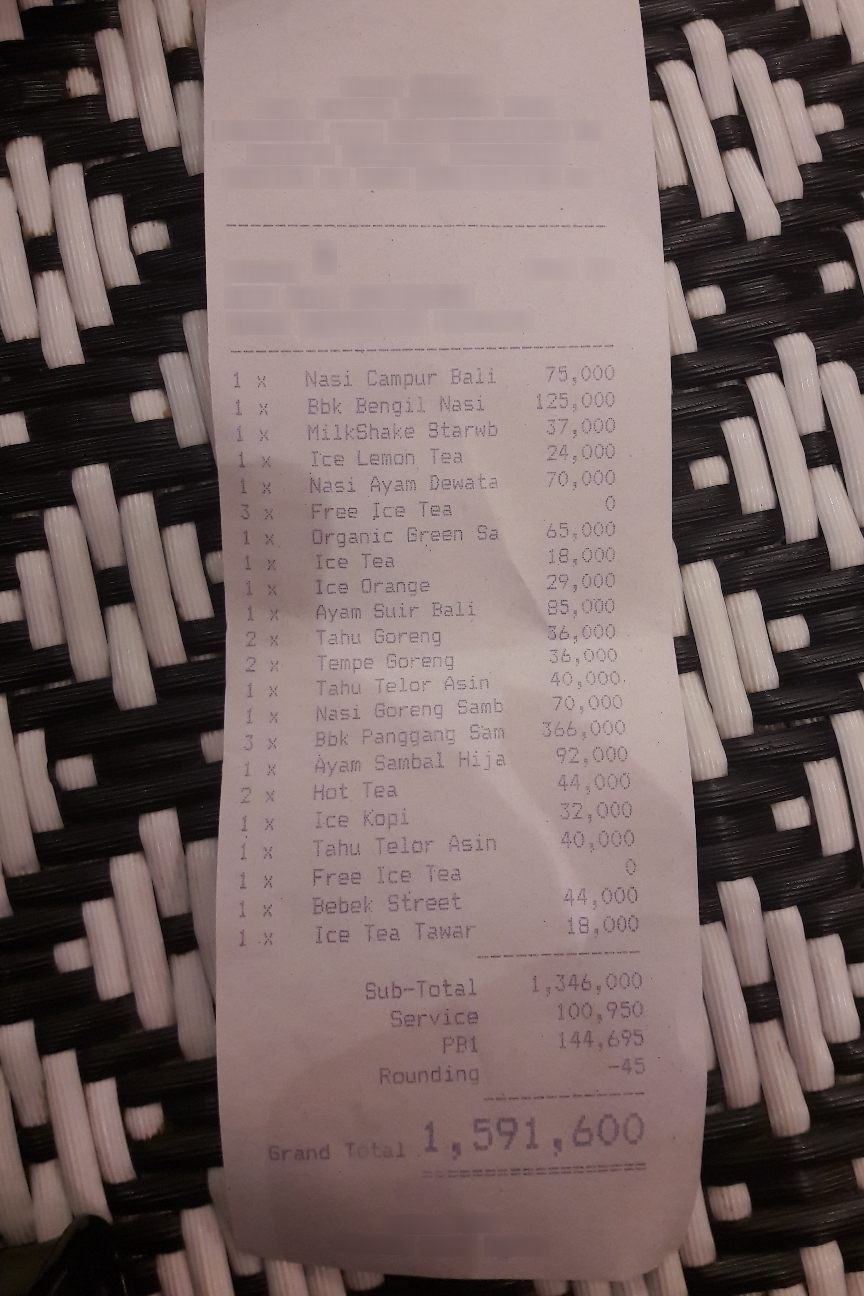

In [ ]:
example = dataset["train"][0]
example["image"]

Take a look at the other information for this example.

In [ ]:
words, boxes, ner_tags = example["words"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '1', 'Nasi', 'Campur', 'Bali', '75,000', '1', 'Bbk', 'Bengil', 'Nasi', '125,000', '1', 'MilkShake', 'Starwb', '37,000', '1', 'Ice', 'Lemon', 'Tea', '24,000', '1', 'Nasi', 'Ayam', 'Dewata', '70,000', '3', 'Free', 'Ice', 'Tea', '0', '1', 'Organic', 'Green', 'Sa', '65,000', '1', 'Ice', 'Tea', '18,000', '1', 'Ice', 'Orange', '29,000', '1', 'Ayam', 'Suir', 'Bali', '85,000', '2', 'Tahu', 'Goreng', '36,000', '2', 'Tempe', 'Goreng', '36,000', '1', 'Tahu', 'Telor', 'Asin', '40,000.', '1', 'Nasi', 'Goreng', 'Samb', '70,000', '3', 'Bbk', 'Panggang', 'Sam', '366,000', '1', 'Ayam', 'Sambal', 'Hija', '92,000', '2', 'Hot', 'Tea', '44,000', '1', 'Ice', 'Kopi', '32,000', '1', 'Tahu', 'Telor', 'Asin', '40,000', '1', 'Free', 'Ice', 'Tea', '0', '1', 'Bebek', 'Street', '44,000', '1', 'Ice', 'Tea', 'Tawar', '18,000', 'Sub-Total', '1,346,000', 'Service', '100,950', 'PB1', '144,695', 'Rounding', '-45

## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `LayoutLMv3Processor`, which internally wraps a `LayoutLMv3FeatureExtractor` (for the image modality) and a `LayoutLMv3Tokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [ ]:
from transformers import AutoProcessor
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

We'll first create `id2label` and label2id mappings, useful for inference. Note that `LayoutLMv3ForTokenClassification` (the model we'll use later on) will simply output an integer index for a particular class (for each token), so we still need to map it to an actual class name.

In [ ]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [ ]:
print(label_list)

['O', 'B-MENU.NM', 'B-MENU.NUM', 'B-MENU.UNITPRICE', 'B-MENU.CNT', 'B-MENU.DISCOUNTPRICE', 'B-MENU.PRICE', 'B-MENU.ITEMSUBTOTAL', 'B-MENU.VATYN', 'B-MENU.ETC', 'B-MENU.SUB_NM', 'B-MENU.SUB_UNITPRICE', 'B-MENU.SUB_CNT', 'B-MENU.SUB_PRICE', 'B-MENU.SUB_ETC', 'B-VOID_MENU.NM', 'B-VOID_MENU.PRICE', 'B-SUB_TOTAL.SUBTOTAL_PRICE', 'B-SUB_TOTAL.DISCOUNT_PRICE', 'B-SUB_TOTAL.SERVICE_PRICE', 'B-SUB_TOTAL.OTHERSVC_PRICE', 'B-SUB_TOTAL.TAX_PRICE', 'B-SUB_TOTAL.ETC', 'B-TOTAL.TOTAL_PRICE', 'B-TOTAL.TOTAL_ETC', 'B-TOTAL.CASHPRICE', 'B-TOTAL.CHANGEPRICE', 'B-TOTAL.CREDITCARDPRICE', 'B-TOTAL.EMONEYPRICE', 'B-TOTAL.MENUTYPE_CNT', 'B-TOTAL.MENUQTY_CNT', 'I-MENU.NM', 'I-MENU.NUM', 'I-MENU.UNITPRICE', 'I-MENU.CNT', 'I-MENU.DISCOUNTPRICE', 'I-MENU.PRICE', 'I-MENU.ITEMSUBTOTAL', 'I-MENU.VATYN', 'I-MENU.ETC', 'I-MENU.SUB_NM', 'I-MENU.SUB_UNITPRICE', 'I-MENU.SUB_CNT', 'I-MENU.SUB_PRICE', 'I-MENU.SUB_ETC', 'I-VOID_MENU.NM', 'I-VOID_MENU.PRICE', 'I-SUB_TOTAL.SUBTOTAL_PRICE', 'I-SUB_TOTAL.DISCOUNT_PRICE', 'I-SUB

In [ ]:
print(id2label)

{0: 'O', 1: 'B-MENU.NM', 2: 'B-MENU.NUM', 3: 'B-MENU.UNITPRICE', 4: 'B-MENU.CNT', 5: 'B-MENU.DISCOUNTPRICE', 6: 'B-MENU.PRICE', 7: 'B-MENU.ITEMSUBTOTAL', 8: 'B-MENU.VATYN', 9: 'B-MENU.ETC', 10: 'B-MENU.SUB_NM', 11: 'B-MENU.SUB_UNITPRICE', 12: 'B-MENU.SUB_CNT', 13: 'B-MENU.SUB_PRICE', 14: 'B-MENU.SUB_ETC', 15: 'B-VOID_MENU.NM', 16: 'B-VOID_MENU.PRICE', 17: 'B-SUB_TOTAL.SUBTOTAL_PRICE', 18: 'B-SUB_TOTAL.DISCOUNT_PRICE', 19: 'B-SUB_TOTAL.SERVICE_PRICE', 20: 'B-SUB_TOTAL.OTHERSVC_PRICE', 21: 'B-SUB_TOTAL.TAX_PRICE', 22: 'B-SUB_TOTAL.ETC', 23: 'B-TOTAL.TOTAL_PRICE', 24: 'B-TOTAL.TOTAL_ETC', 25: 'B-TOTAL.CASHPRICE', 26: 'B-TOTAL.CHANGEPRICE', 27: 'B-TOTAL.CREDITCARDPRICE', 28: 'B-TOTAL.EMONEYPRICE', 29: 'B-TOTAL.MENUTYPE_CNT', 30: 'B-TOTAL.MENUQTY_CNT', 31: 'I-MENU.NM', 32: 'I-MENU.NUM', 33: 'I-MENU.UNITPRICE', 34: 'I-MENU.CNT', 35: 'I-MENU.DISCOUNTPRICE', 36: 'I-MENU.PRICE', 37: 'I-MENU.ITEMSUBTOTAL', 38: 'I-MENU.VATYN', 39: 'I-MENU.ETC', 40: 'I-MENU.SUB_NM', 41: 'I-MENU.SUB_UNITPRICE', 42:

Next, we'll define a function which we can apply on the entire dataset.

In [ ]:
def prepare_examples(examples):
  images = examples[image_column_name] ##if you use an image path, this will need to be updated to read the image in
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})



Next let's apply this to our train and eval datasets.

In [ ]:
##I used this code to subset the data for building learning curves, 
# you will probably ignore this and train on all the data
#train_sample = dataset["train"].shuffle(seed=42).select(range(300))

train_sample = dataset["train"]
train_dataset = train_sample.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

You can see the effect of the processing on the train dataset

In [ ]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 800
})

Grab an example for helping some of the initial conditions

In [ ]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> x x x x x x x x x x x x x x x x x x x x x x 1 Nasi Campur Bali 75,000 1 Bbk Bengil Nasi 125,000 1 MilkShake Starwb 37,000 1 Ice Lemon Tea 24,000 1 Nasi Ayam Dewata 70,000 3 Free Ice Tea 0 1 Organic Green Sa 65,000 1 Ice Tea 18,000 1 Ice Orange 29,000 1 Ayam Suir Bali 85,000 2 Tahu Goreng 36,000 2 Tempe Goreng 36,000 1 Tahu Telor Asin 40,000. 1 Nasi Goreng Samb 70,000 3 Bbk Panggang Sam 366,000 1 Ayam Sambal Hija 92,000 2 Hot Tea 44,000 1 Ice Kopi 32,000 1 Tahu Telor Asin 40,000 1 Free Ice Tea 0 1 Bebek Street 44,000 1 Ice Tea Tawar 18,000 Sub-Total 1,346,000 Service 100,950 PB1 144,695 Rounding -45 Grand Total 1,591,600</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

Next, we set the format to PyTorch.

In [ ]:
train_dataset.set_format("torch")

Let's verify that everything was created properly:

In [ ]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.
The training arguments I set here:
- max steps for how long I thought it would take to train - you may need more steps
- batch_size was tweaked based on GPU memory
- push to hub was set to save my model to the hugging face hub
- evaluation strategy, steps was set to periodically evaluate the model
- metric for best model was to save the best checkpoint model based on accuracy

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="layoutlmv3-finetuned-cord_100",
                                  max_steps=2500,
                                  per_device_train_batch_size=5,
                                  per_device_eval_batch_size=5,
                                  push_to_hub=True,  # after training, we'd like to push our model to the hub
                                  push_to_hub_model_id=f"layoutlmv3-finetuned-cord_100", 
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=250,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy")

/usr/local/lib/python3.7/dist-packages/transformers/training_args.py:1227: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case rajistics/layoutlmv3-finetuned-cord_100).
  FutureWarning,


We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [ ]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/rajistics/layoutlmv3-finetuned-cord_100 into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.52k/481M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

Download file runs/Aug29_00-12-22_f2181929f807/1661731952.307264/events.out.tfevents.1661731952.f2181929f807.7…

Clean file training_args.bin:  30%|###       | 1.00k/3.30k [00:00<?, ?B/s]

Clean file runs/Aug29_00-12-22_f2181929f807/1661731952.307264/events.out.tfevents.1661731952.f2181929f807.7592…

Download file runs/Aug29_00-12-22_f2181929f807/events.out.tfevents.1661731952.f2181929f807.7592.0:  26%|##6   …

Clean file runs/Aug29_00-12-22_f2181929f807/events.out.tfevents.1661731952.f2181929f807.7592.0:   8%|7        …

Clean file pytorch_model.bin:   0%|          | 1.00k/481M [00:00<?, ?B/s]

max_steps is given, it will override any value given in num_train_epochs


## Train the model

Let's train!

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 800
  Num Epochs = 16
  Instantaneous batch size per device = 5
  Total train batch size (w. parallel, distributed & accumulation) = 5
  Gradient Accumulation steps = 1
  Total optimization steps = 2500
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
250,No log,1.016008,0.746499,0.797904,0.771346,0.806876


***** Running Evaluation *****
  Num examples = 100
  Batch size = 5
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: ignored

Let's push the final model to the hub

In [ ]:
trainer.push_to_hub("layoutlmv3-finetuned-cord_100")

Evaluate the final model

In [ ]:
trainer.evaluate()

## Inference

This section loads the model from the hub and does not assume we have just trained the model. This is a realistic scenario for me, as Google Colab often makes me use multiple sessions.

You will have to update this with your particular repo/model name

In [ ]:
from transformers import AutoModelForTokenClassification, AutoProcessor

model = AutoModelForTokenClassification.from_pretrained("rajistics/layoutlmv3-finetuned-cord_500")

https://huggingface.co/rajistics/layoutlmv3-finetuned-cord_500/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpj1todq8d


storing https://huggingface.co/rajistics/layoutlmv3-finetuned-cord_500/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/1f53deca8c11e15a42dea07eda43b6441ec70fd3ecb08c3a469c962facafbb4e.61617400420ef53b87965f4aa81e3bdb8f4ee782417a173f1dd7cae1784ce255
creating metadata file for /root/.cache/huggingface/transformers/1f53deca8c11e15a42dea07eda43b6441ec70fd3ecb08c3a469c962facafbb4e.61617400420ef53b87965f4aa81e3bdb8f4ee782417a173f1dd7cae1784ce255
loading configuration file https://huggingface.co/rajistics/layoutlmv3-finetuned-cord_500/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1f53deca8c11e15a42dea07eda43b6441ec70fd3ecb08c3a469c962facafbb4e.61617400420ef53b87965f4aa81e3bdb8f4ee782417a173f1dd7cae1784ce255
Model config LayoutLMv3Config {
  "_name_or_path": "rajistics/layoutlmv3-finetuned-cord_500",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier

storing https://huggingface.co/rajistics/layoutlmv3-finetuned-cord_500/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/0fea2fd13f9182d252564568c28891f7bf51b78ac8f231fc536665a42d6a6744.6e9bc9efb62b1f631425321fcd6d21684e5a4648de7dad0dd32b1f73f7c1427a
creating metadata file for /root/.cache/huggingface/transformers/0fea2fd13f9182d252564568c28891f7bf51b78ac8f231fc536665a42d6a6744.6e9bc9efb62b1f631425321fcd6d21684e5a4648de7dad0dd32b1f73f7c1427a
loading weights file https://huggingface.co/rajistics/layoutlmv3-finetuned-cord_500/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/0fea2fd13f9182d252564568c28891f7bf51b78ac8f231fc536665a42d6a6744.6e9bc9efb62b1f631425321fcd6d21684e5a4648de7dad0dd32b1f73f7c1427a
All model checkpoint weights were used when initializing LayoutLMv3ForTokenClassification.

All the weights of LayoutLMv3ForTokenClassification were initialized from the model checkpoint at rajistics/layoutlmv3-finetuned-cord_

Move the model to the GPU

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

Setup the preprocessing for the data and load one example for testing

In [ ]:
#from transformers import LayoutLMv3Processor

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
example = dataset["test"][0]
image = example['image']
print(example.keys())

encoded_inputs = processor(example['image'], example['words'], boxes=example['bboxes'], word_labels=example['ner_tags'],
                           padding="max_length", truncation=True, return_tensors="pt")

loading feature extractor configuration file https://huggingface.co/microsoft/layoutlmv3-base/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/e90f549bb33101e8141284f850ad2b907e919417da746aca394c6a403dc4151f.4f4fbbd7db79618fdf8c9a37cf26bd2881f493d22820d058af4c37bb42d657ba
loading configuration file https://huggingface.co/microsoft/layoutlmv3-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d36fc65e1be5027d85f26395edf758458d2e5a8011205c2f3031c027858d3c68.2c9bc93b2b716da4229e8eeaa23dfede27509aea0c41743d33b7d1a422a4ee39
Model config LayoutLMv3Config {
  "_name_or_path": "microsoft/layoutlmv3-base",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "i

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image'])


NOTE: at "true inference" time, you don't have access to labels, see the end of this notebook how you can use `offset_mapping` in that case.

In [ ]:
labels = encoded_inputs.pop('labels').squeeze().tolist()
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(device)

Get predictions

In [ ]:
outputs = model(**encoded_inputs)
print(outputs.logits.shape)

torch.Size([1, 512, 61])


Convert the predictions into something useful for us

So let's only compare predictions and labels at positions where the label isn't -100. We also want to have the bounding boxes of these (unnormalized):

In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

Set features

In [ ]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

Get labels

In [ ]:
# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

Get Predictions

In [ ]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

true_predictions = [id2label[prediction] for prediction, label in zip(predictions, labels) if label != -100]
true_labels = [id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

Draws the predictions

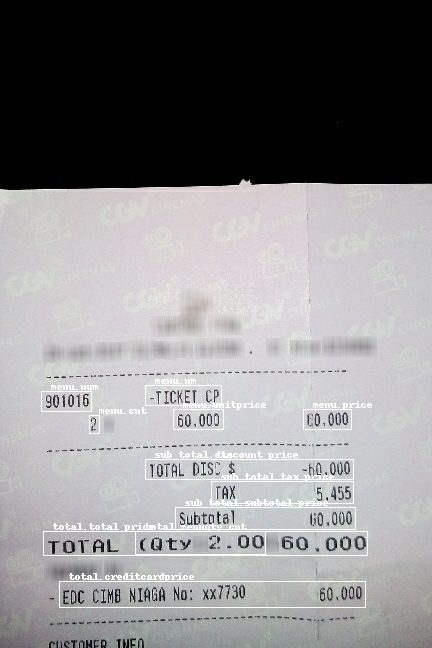

In [ ]:
from PIL import ImageDraw
from PIL import Image, ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    #draw.rectangle(box, outline=label2color[predicted_label])
    draw.rectangle(box)
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, font=font)
    #draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

## Batch inference

Preprocess the data

In [ ]:
def prepare_examples(examples):
  images = examples[image_column_name] ##if you use an image path, this will need to be updated to read the image in
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding


Features

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

Metrics for Evaluation

In [ ]:
# Metrics
from datasets import load_metric
import numpy as np

metric = load_metric("seqeval")
return_entity_level_metrics = True


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }


Preprocess dataset

In [ ]:
val_dataset = dataset['validation'].map(prepare_examples,
                                      batched=True,
                                      remove_columns=dataset['validation'].column_names,
                                      features=features)

  0%|          | 0/1 [00:00<?, ?ba/s]

Use the Trainer for batch inference
- adjust the batch size to what works for your setup

In [ ]:
from transformers import TrainingArguments, Trainer

test_args = TrainingArguments(
    output_dir = "layoutlmv3-finetuned-cord",
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = 5,   
    dataloader_drop_last = False    
)

# init trainer
trainer = Trainer(
              model = model, 
              args = test_args, 
              compute_metrics = compute_metrics)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:

#predictionsT, labelsT, metricsT = trainer.predict(eval_dataset)
predictionsV, labelsV, metricsV = trainer.predict(val_dataset)

***** Running Prediction *****
  Num examples = 100
  Batch size = 5


In [ ]:
metricsV

{'test_loss': 0.20967219769954681,
 'test_MENU.CNT_precision': 0.9905660377358491,
 'test_MENU.CNT_recall': 0.9813084112149533,
 'test_MENU.CNT_f1': 0.9859154929577464,
 'test_MENU.CNT_number': 214,
 'test_MENU.DISCOUNTPRICE_precision': 1.0,
 'test_MENU.DISCOUNTPRICE_recall': 0.75,
 'test_MENU.DISCOUNTPRICE_f1': 0.8571428571428571,
 'test_MENU.DISCOUNTPRICE_number': 4,
 'test_MENU.NM_precision': 0.9817351598173516,
 'test_MENU.NM_recall': 0.9684684684684685,
 'test_MENU.NM_f1': 0.9750566893424036,
 'test_MENU.NM_number': 222,
 'test_MENU.NUM_precision': 1.0,
 'test_MENU.NUM_recall': 1.0,
 'test_MENU.NUM_f1': 1.0,
 'test_MENU.NUM_number': 4,
 'test_MENU.PRICE_precision': 0.9908256880733946,
 'test_MENU.PRICE_recall': 0.9642857142857143,
 'test_MENU.PRICE_f1': 0.9773755656108598,
 'test_MENU.PRICE_number': 224,
 'test_MENU.SUB_CNT_precision': 0.8857142857142857,
 'test_MENU.SUB_CNT_recall': 0.96875,
 'test_MENU.SUB_CNT_f1': 0.9253731343283582,
 'test_MENU.SUB_CNT_number': 32,
 'test_MENU

## Note: inference when you don't have labels

The code above used the `labels` to determine which tokens were at the start of a particular word or not. Of course, at inference time, you don't have access to any labels. In that case, you can leverage the `offset_mapping` returned by the tokenizer. I do have a notebook for that (for LayoutLMv2, but it's equivalent for LayoutLMv3) [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/FUNSD/True_inference_with_LayoutLMv2ForTokenClassification_%2B_Gradio_demo.ipynb).